### Get Pelvis data - LPF + Norm (save Figure + csv)
### Get oneHot encoded Label 
### Interpolation (Univariate Interpolation)

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output

from scipy.signal import butter, lfilter, filtfilt  
from scipy.interpolate import UnivariateSpline  # missing value -> np.nan -> to zero -> 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)
import tensorflow as tf 

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

rootDir = "/DockerProjects/Dataset/TUG/trainSet"
expertFolder = "/" + "saveResults_최윤정"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

print(" [Home Dir.] Current path", os.getcwd())  

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/0_temporalCNN_wLabel
 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/saveResults_최윤정/0_sideView


### Train/Test Subject Split

In [2]:
def get_subjectList(datasetDir, shuffle = False):      
    expDates = next(os.walk(datasetDir))[1]   #['2020_11_03', '2020_11_20_v1', '2020_11_20_v2', '2020_11_23', '2020_12_09', '2020_12_30']
    subject_number = 0
    subjects_list = []
    
    for dateFolder in expDates:
        dateDir = os.path.join(datasetDir, dateFolder)   # D:/바탕화면/Dataset/TUG/trainSet/2021_01_24_saveResults_최윤정/0_sideView\2020_11_03
        tmpSubjects = next(os.walk(dateDir))[1]
        subjects_list.append(tmpSubjects)  


    # ------ 2D -> 1D [[sub1, sub2], [sub3, sub4]] -> [sub1, sub2, sub3, sub4]
    subjects = []
    for eachSub in subjects_list:
        for sub in eachSub:
            if ".ipynb_checkpoints" == sub:
                pass
            else:
                subjects.append(sub)
                subject_number +=1


    if shuffle:
        np.random.shuffle(subjects)
        
    print(" 1D sub list: " , subjects, len(subjects))
    return subjects, subject_number

def fold_trainNames(subList, Kfold_num = 5):
    assert (Kfold_num is not 0), print("check kfold_num. should not be zero")
    Fold_results =[]
    kfold = KFold(n_splits=  Kfold_num)
    
    for trainIdx, testIdx in kfold.split(subList):
        Fold_results.append([trainIdx, testIdx])      
        
    train_Fold= []
    test_Fold = []
        
    for i in range(Kfold_num):    # bind fold pair
        tmp_train = []
        tmp_test = []
        for subIdx in range(len(subList)): 
            if subIdx in Fold_results[i][0]:  # -- K-fold train
                tmp_train.append(subList[subIdx])
               
            if subIdx in Fold_results[i][1]:  # -- K-fold test
                tmp_test.append(subList[subIdx])
          
        train_Fold.append(tmp_train)
        test_Fold.append(tmp_test)
        print("\t [process]", i, "-fold:", train_Fold[i], "\n\t\t\t   ,", test_Fold[i])
    print("\n [results]  trainSet: ", len(train_Fold[0]) , " 명 , testSet: ", len(test_Fold[0]), " 명" )
    
    return train_Fold, test_Fold

In [3]:
train_ratio = 0.6
valid_ratio = 0.2

arbitrarySplit = True
Kfold = False
Kfold_num = 5 # if kfold_num = 0 (arbitrary train/test set will be used)s


numFeature = 4 # time + numPelvis = 4
numPelvis = 3 
numActions = 6
dataset_columns = numFeature + numActions

subList, numOfsubjects = get_subjectList(datasetDir, shuffle = False) ; print("\n")

if arbitrarySplit is not True:
    if Kfold:
        print(" K-fold : ", Kfold_num)
        trainFold, testFold = fold_trainNames(subList = subList, Kfold_num = Kfold_num)

        selected_foldNum = 0 

        train_subjects = trainFold[selected_foldNum]
        test_subjects = testFold[selected_foldNum]
        print("\t ------>  Selected Fold num: %d \n   Train Subjects: %s\n   Test Subjects: %s"%(selected_foldNum, train_subjects, test_subjects))
    else:

        trainSub_number = np.round( (numOfsubjects*train_ratio), 0).astype(int)
        validSub_number = np.round( (numOfsubjects*valid_ratio), 0).astype(int)
        testSub_number = numOfsubjects - trainSub_number - validSub_number

        train_subjects = subList[ :trainSub_number]
        valid_subjects = subList[ trainSub_number : (trainSub_number+validSub_number)]
        test_subjects = subList[ (trainSub_number+validSub_number): ]
        print("   No-fold \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
        print("\n\t--> # of train  : " + str(trainSub_number) +" 명 ,  # of valid : "+ str(validSub_number) + " 명 ,  # of test :" + str(testSub_number) + "명")

else:

#     normal_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'lhs', 'NHJ_60', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj', 'cyj2', 'jdh', 'jek', 'kch', 'ryu'] 
#     patients_subjects = ['JDW_tug']
#     copy_patients_subjects = ['BYS_TUG', 'CYJ_TUG', 'PHE_TUG', 'YSJ_TUG'] 

#     train_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'pss', 'yjh', 'lhs', 'kyh', 'nhs', 'kw', 'NHJ_60', 'pjh', 'rjh', 'ryu', 'PHE_TUG', 'YSJ_TUG'] 
#     valid_subjects = ['ryu', 'cyh','jdh', 'cbd', 'CYJ_TUG'] 
#     test_subjects =  ['JDW_tug', 'BYS_TUG', 'kch', 'bys', 'jek', 'cyj', 'cyj2' ]
    
    
#     train_subjects = ['bys_tug', 'cbd_tug', 'cyj_tug', 'kw', 'kyh', 'nhs', 'pjh', 'pss', 'rjh', 'yjh', 'bys', 'cbd', 'cyj'] 
#     valid_subjects = ['cyj2', 'jdh', 'jek', 'lhs' ] 
#     test_subjects =  ['kch', 'ryu', 'NHJ_60']
    
    train_subjects = ['PHE_TUG', 'kw', 'CYJ_TUG', 'BYS_TUG', 'KYS_TUG', 'RJD_TUG', 'SRK_TUG', 'bys_tug', 'cbd_tug', 'cyj_tug', 'rjh', 'cbd', 'kch', 'bys', 'jek', 'cyj', 'cyj2'] 
    valid_subjects = ['pss', 'yjh', 'lhs', 'kyh', 'nhs', 'YSJ_TUG'] 
    test_subjects =  ['NHJ_60', 'pjh', 'jdh', 'ryu', 'cyh', 'JDW_tug']
    
    print(" No-fold --- (arbitrary) \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)

 1D sub list:  ['bys_tug', 'cbd_tug', 'cyj_tug', 'pss', 'yjh', 'lhs', 'kyh', 'nhs', 'kw', 'NHJ_60', 'pjh', 'rjh', 'KYS_TUG', 'ryu', 'cyh', 'JDW_tug', 'jdh', 'cbd', 'kch', 'bys', 'jek', 'cyj', 'cyj2'] 23


 No-fold --- (arbitrary) 	 [results] 
	 Train:  ['PHE_TUG', 'kw', 'CYJ_TUG', 'BYS_TUG', 'KYS_TUG', 'RJD_TUG', 'SRK_TUG', 'bys_tug', 'cbd_tug', 'cyj_tug', 'rjh', 'cbd', 'kch', 'bys', 'jek', 'cyj', 'cyj2'] 
	 Valid:  ['pss', 'yjh', 'lhs', 'kyh', 'nhs', 'YSJ_TUG'] 
	 Test:  ['NHJ_60', 'pjh', 'jdh', 'ryu', 'cyh', 'JDW_tug']


In [4]:
def get_rawData(csvFile):
    
    interCheck = False
    # Some csv file has " " (blank) --- read as string then convert to float
    csv_data_ = np.loadtxt(csvFile, delimiter=',', dtype=str, skiprows=2, usecols=(0,1,2,3)) 
    frameNum = csv_data_[:,0].astype(np.int)  # int로 type conversion
    max_frame = len(csv_data_[:,0])
    
    rawPelvis_x = np.array(frameNum).astype(np.float32)
    rawPelvis_y = np.array(frameNum).astype(np.float32)
    rawPelvis_z = np.array(frameNum).astype(np.float32)
    

    #--- Interpolating 
    for i, v in enumerate(csv_data_[:, 1]):
        if v == " ": # if it has " " (blank)  --> change to  nan for interpolating 
            interCheck = True
            csv_data_[i,1] = np.nan
            csv_data_[i,2] = np.nan
            csv_data_[i,3] = np.nan
        rawPelvis_x[i] = csv_data_[i, 1].astype(np.float32)
        rawPelvis_y[i] = csv_data_[i, 2].astype(np.float32)
        rawPelvis_z[i] = csv_data_[i, 3].astype(np.float32)
  
    if interCheck: 
        w_x = np.isnan(rawPelvis_x) 
        rawPelvis_x[w_x] = 0
        Fx = UnivariateSpline(frameNum,rawPelvis_x,w=~w_x)
        newPelvis_x = Fx(frameNum)

        w_y = np.isnan(rawPelvis_y) 
        rawPelvis_y[w_y] = 0
        Fy = UnivariateSpline(frameNum,rawPelvis_y,w=~w_y)
        newPelvis_y = Fy(frameNum)

        w_z = np.isnan(rawPelvis_z) 
        rawPelvis_z[w_z] = 0
        Fz = UnivariateSpline(frameNum,rawPelvis_z,w=~w_z)
        newPelvis_z = Fz(frameNum)

        # 그린다.
#         plt.figure(figsize=(16, 5))
#         plt.subplot(131)
#         plt.plot(frameNum, newPelvis_x, '-')
#         plt.subplot(132)
#         plt.plot(frameNum, newPelvis_y, '-')
#         plt.subplot(133)
#         plt.plot(frameNum, newPelvis_z, '-')
    else:
        newPelvis_x = rawPelvis_x
        newPelvis_y = rawPelvis_y
        newPelvis_z = rawPelvis_z
        
    
    
    timeData = np.loadtxt(csvFile, delimiter=',', skiprows=2, dtype=np.float32, usecols=[97, 98, 99, 100]) #  # skiprows=2 (header + first data.. 가끔 첫 줄 data 이상함)
    timestamp_diff_msec = np.array([rawPelvis_x])
    for i in range(max_frame):
        before_time_msec = timeData[i-1, 0] * 60 * 60 * 1000 + timeData[i-1, 1] * 60 * 1000 +  timeData[i-1, 2] * 1000 + timeData[i-1, 3] 
        current_time_msec = timeData[i, 0] * 60 * 60 * 1000 + timeData[i, 1] * 60 * 1000 + timeData[i, 2] * 1000 + timeData[i, 3]
        if i is 0:
            timestamp_diff_msec[0, i] = 0
        else:
            timestamp_diff_msec[0, i] = int(current_time_msec - before_time_msec)
                            
        time_sum_msec = 0
        eachTimestamp_sec = np.array(frameNum, dtype=float) # sec (?,1)
        for timeIdx in range(timestamp_diff_msec.shape[1]):
            time_sum_msec = int(time_sum_msec + timestamp_diff_msec[0, timeIdx])
            eachTimestamp_sec[timeIdx] = time_sum_msec / 1000  
  
    return frameNum, eachTimestamp_sec, newPelvis_x, newPelvis_y, newPelvis_z

    
def get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max'):    
    if normMethod == "min_max":
        normPelvis_x = (pelvis_x -np.min(pelvis_x)) / ( np.max(pelvis_x) - np.min(pelvis_x))
        normPelvis_y = (pelvis_y -np.min(pelvis_y)) / ( np.max(pelvis_y) - np.min(pelvis_y))
        normPelvis_z = (pelvis_z -np.min(pelvis_z)) / ( np.max(pelvis_z) - np.min(pelvis_z))
        
    elif normMethod == "z_score":
        normPelvis_x = (pelvis_x -np.mean(pelvis_x)) / np.std(pelvis_x)
        normPelvis_y = (pelvis_y -np.mean(pelvis_y)) / np.std(pelvis_y)
        normPelvis_z = (pelvis_z -np.mean(pelvis_z)) / np.std(pelvis_z)
        
    return normPelvis_x, normPelvis_y, normPelvis_z

def get_LPFData(pelvis_x, pelvis_y, pelvis_z, cutoff_freq = 0.5, order=1):
    sampling_freq = 30
    number_of_samples = len(pelvis_y)
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = butter(order, normalized_cutoff_freq)
    Filtered_x = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_x)  # Phase shift 없음
    Filtered_y = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_y)
    Filtered_z = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_z)
    return Filtered_x, Filtered_y, Filtered_z


def getLPF_PelvisData(csvFile):
    rawData = np.loadtxt(csvFile, delimiter=",")
    timestamp = rawData[:,0]
    pelvis_x = rawData[:,1]
    pelvis_y = rawData[:,2]
    pelvis_z = rawData[:,3]
    actionList = rawData[:,4:]
    return timestamp, pelvis_x, pelvis_y, pelvis_z, actionList

  
def pltSkeleton(timeSec, pelvis_x, pelvis_y, pelvis_z, saveDir, saveFile,  actLabel, addFolder="raw", actSplit=False, save=True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))
    title = addFolder + "_" + saveFile
    ax[0].set_title(title)
    ax[0].set_ylabel('Side axis(X) of Pelvis [mm]')
    ax[1].set_ylabel('Vertical axis(Y) of Pelvis [mm]')
    ax[2].set_ylabel('Depth Axis of Pelvis [mm]')
    ax[2].set_xlabel('Time [Sec]')
    ax[0].plot(timeSec, pelvis_x, "r--", lw=1, label="pelvis_x")
    ax[1].plot(timeSec, pelvis_y, "g--", lw=1, label="pelvis_y")
    ax[2].plot(timeSec, pelvis_z, "b--", lw=1, label="pelvis_z")
    
    if actSplit:
        for i in range(3):
            if i ==0:
                ax[i].axvline(x=timeSec[actLabel[0]], color='r', linestyle="--", linewidth=3, label="start move")
                ax[i].axvline(x=timeSec[actLabel[1]], color='r', linestyle=":", linewidth=3, label="start walk")
                
                ax[i].axvline(x=timeSec[actLabel[2]], color='k', linestyle="--", linewidth=3, label="start turn")
                ax[i].axvline(x=timeSec[actLabel[3]], color='k', linestyle=":", linewidth=3, label="end turn")
                
                ax[i].axvline(x=timeSec[actLabel[4]], color='g', linestyle="--", linewidth=3, label="start sit")
                ax[i].axvline(x=timeSec[actLabel[5]], color='g', linestyle=":", linewidth=3, label="end sit")
            else:
                ax[i].axvline(x=timeSec[actLabel[0]], color='r', linestyle="--", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[1]], color='k', linestyle="--", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[2]], color='g', linestyle="--", linewidth=3)

                ax[i].axvline(x=timeSec[actLabel[3]], color='r', linestyle=":", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[4]], color='k', linestyle=":", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[5]], color='g', linestyle=":", linewidth=3)

    fig.legend()
    plt.show()
    
    if save:
        if  os.path.isfile(saveDir+"/"+title):
            os.remove(saveDir+"/"+title)
        fig.savefig(saveDir+"/"+title)
    plt.close()
           
      

In [5]:
def get_actFrameNumber(csvFile): 
    actFrame = []
    with open(csvFile, 'r', encoding='utf-8') as readCSV:
        data = readCSV.read()
        lines = data.split("\n") # lines[0] = header, [1] = act label data
        tmpLabel = lines[1].split(",")
       
        for i in range(len(tmpLabel)):           
            actFrame.append( int(tmpLabel[i].split("_")[1].split(".")[0]) ) 
        return actFrame   
    
def sliding_window(timestamp, data_x, data_y, lookback_window=3):
    time = []
    x = []
    y = []
    enc = MinMaxScaler(feature_range = (0, 1))
    enc_y = enc.fit_transform(data_y)
    for i in range(lookback_window, len(data_x)+1):
        time.append(timestamp[i-1])
        x.append(data_x[i - lookback_window:i])
        y.append(data_y[i-1])
  
    x = np.array(x)
    x = x.reshape(-1, lookback_window, numPelvis, 1)
    
    y = np.array(y)
    time = np.array(time)
   
    return time, x, y, enc

# ------------------  sit, sit-to-stand, walk, turn, walkback, stand-to-sit , sit(6 action) ...   "Act6_lpf_"
def convert_act2oneHot(actFrame, frameNum):
    actionList = []
    for timeIdx in range(len(frameNum)):
        if (timeIdx < actFrame[0]):  # frame Num < move start fram (sit)
            actionList.append(np.array([1, 0, 0, 0, 0, 0],dtype=np.int))
                    # moveStartIdx ~ startWalk 까지 (sit-to-stand)
        elif (timeIdx >= actFrame[0]) and (timeIdx < actFrame[1]):
            actionList.append(np.array([0, 1, 0, 0, 0, 0],dtype=np.int))
                    # startWalk ~ turnStartIdx 까지 (walk)
        elif (timeIdx >= actFrame[1]) and (timeIdx < actFrame[2]):
            actionList.append(np.array([0, 0, 1, 0, 0, 0],dtype=np.int))
                    # turnStartIdx ~ turnEndIdx 까지 (turn)
        elif (timeIdx >= actFrame[2]) and (timeIdx < actFrame[3]):
            actionList.append(np.array([0, 0, 0, 1, 0, 0],dtype=np.int))
                    # turnEndIdx ~ startSitIdx 까지 (walkback)
        elif (timeIdx >= actFrame[3]) and (timeIdx < actFrame[4]):
            actionList.append(np.array([0, 0, 0, 0, 1, 0],dtype=np.int))
                    # startSitIdx ~ moveEndIdx 까지 (stand-to-sit)
        elif (timeIdx >= actFrame[4]) and (timeIdx < actFrame[5]):
            actionList.append(np.array([0, 0, 0, 0, 0, 1],dtype=np.int))
            
        elif (timeIdx >= actFrame[5]):
            actionList.append(np.array([1, 0, 0, 0, 0, 0],dtype=np.int))
        
            
        else:
            AssertionError("Check getLabel_forEveryTrial func. in utils_labeling_all")
        oneTrial_actionList = np.array(actionList)
    return np.array(oneTrial_actionList)


# #------------------ Origin... sit, sit-to-stand, walk, turn, stand-to-sit (5action)
# def convert_act2oneHot(actFrame, frameNum):
#     actionList = []
#     for timeIdx in range(len(frameNum)):
#         if (timeIdx < actFrame[0]):  # frame Num < move start fram (sit)
#             actionList.append(np.array([1, 0, 0, 0, 0],dtype=np.int))
#                     # moveStartIdx ~ startWalk 까지 (sit-to-stand)
#         elif (timeIdx >= actFrame[0]) and (timeIdx < actFrame[1]):
#             actionList.append(np.array([0, 1, 0, 0, 0],dtype=np.int))
#                     # startWalk ~ turnStartIdx 까지 (walk)
#         elif (timeIdx >= actFrame[1]) and (timeIdx < actFrame[2]):
#             actionList.append(np.array([0, 0, 1, 0, 0],dtype=np.int))
#                     # turnStartIdx ~ turnEndIdx 까지 (turn)
#         elif (timeIdx >= actFrame[2]) and (timeIdx < actFrame[3]):
#             actionList.append(np.array([0, 0, 0, 1, 0],dtype=np.int))
#                     # turnEndIdx ~ startSitIdx 까지 (walk)
#         elif (timeIdx >= actFrame[3]) and (timeIdx < actFrame[4]):
#             actionList.append(np.array([0, 0, 1, 0, 0],dtype=np.int))
#                     # startSitIdx ~ moveEndIdx 까지 (stand-to-sit)
#         elif (timeIdx >= actFrame[4]) and (timeIdx < actFrame[5]):
#             actionList.append(np.array([0, 0, 0, 0, 1],dtype=np.int))
            
#         elif (timeIdx >= actFrame[5]):
#             actionList.append(np.array([1, 0, 0, 0, 0],dtype=np.int))
        
            
#         else:
#             AssertionError("Check getLabel_forEveryTrial func. in utils_labeling_all")
#         oneTrial_actionList = np.array(actionList)
#     return np.array(oneTrial_actionList)


#------------------ dtw 용... Sit, Sit-to-stand, Walk, Turn, WalkBack, Sit-back ( 6 action)  split ... Acc = 80 %
# def convert_act2oneHot(actFrame, frameNum):
#     actionList = []
#     for timeIdx in range(len(frameNum)):
#         if (timeIdx < actFrame[0]):  # frame Num < move start fram (sit)
#             actionList.append(np.array([1, 0, 0, 0, 0, 0],dtype=np.int))
#                     # moveStartIdx ~ startWalk 까지 (sit-stand)
#         elif (timeIdx >= actFrame[0]) and (timeIdx < actFrame[1]):
#             actionList.append(np.array([0, 1, 0, 0, 0, 0],dtype=np.int))
#                     # startWalk ~ turnStartIdx 까지 (walk)
#         elif (timeIdx >= actFrame[1]) and (timeIdx < actFrame[2]):
#             actionList.append(np.array([0, 0, 1, 0, 0, 0],dtype=np.int))
#                     # turnStartIdx ~ turnEndIdx 까지 (turn)
#         elif (timeIdx >= actFrame[2]) and (timeIdx < actFrame[3]):
#             actionList.append(np.array([0, 0, 0, 1, 0, 0],dtype=np.int))
#                     # turnEndIdx ~ startSitIdx 까지 (walk-back)
#         elif (timeIdx >= actFrame[3]) and (timeIdx < actFrame[4]):
#             actionList.append(np.array([0, 0, 0, 0, 1, 0],dtype=np.int))
#                     # startSitIdx ~ moveEndIdx 까지 (Sit-back)
#         elif (timeIdx >= actFrame[4]):
#             actionList.append(np.array([0, 0, 0, 0, 0, 1],dtype=np.int))
            
            
#         else:
#             AssertionError("Check getLabel_forEveryTrial func. in utils_labeling_all")
#         oneTrial_actionList = np.array(actionList)
#     return np.array(oneTrial_actionList)


In [6]:
def readLPF_createDataset(train_subjects, test_subjects, lookback_window = 8):
    train_x = np.zeros((0, lookback_window,numPelvis , 1)) 
    train_y = np.zeros((0, numActions))
    
    valid_x = np.zeros((0, lookback_window, numPelvis, 1))
    valid_y = np.zeros((0, numActions))
    
    test_x = np.zeros((0, lookback_window, numPelvis,1 ))
    test_y = np.zeros((0, numActions)) 
    
    total_Trials = 0
    for dirpath, foldername, files in sorted(os.walk(datasetDir)):
#         clear_output(wait=True)
        actPath = None
        pelvisPath= None
        actFrame = []
        if ".ipynb_checkpoints" in dirpath:
            continue
        else:
            for filename in sorted(files):
                if ".csv" in filename:
                    if "Act6_lpf" in filename:     # lpf_, Act5_lpf , labeled_ (Origin93)
                        pelvisPath = dirpath    
                        subname = dirpath.split("/")[-2] 
                        pelvis_csv = os.path.join(dirpath, filename)

                        timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  = getLPF_PelvisData(pelvis_csv)  # raw                 
     
                        
                        total_Trials +=1   

                            
                        pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
                        actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
                        blockTime, blockPelvis, blockLable, enc = sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData, lookback_window=lookback_window) # pelvis - (327, 8, 3)
#                         print(dirpath, "\t", blockLable.shape)
                        if Kfold is not True:
                            if subname in train_subjects:
                                train_x = np.append(train_x, blockPelvis, axis = 0 )
                                train_y = np.append(train_y, blockLable, axis = 0 )

                            elif subname in valid_subjects:
                                valid_x = np.append(valid_x, blockPelvis, axis = 0 )
                                valid_y = np.append(valid_y, blockLable, axis = 0 )

                            elif subname in test_subjects:
                                test_x = np.append(test_x, blockPelvis, axis = 0 )
                                test_y = np.append(test_y, blockLable, axis = 0 )    
                        else:
                            if subname in train_subjects:
                                train_x = np.append(train_x, blockPelvis, axis = 0 )
                                train_y = np.append(train_y, blockLable, axis = 0 )
                            elif subname in test_subjects:
                                test_x = np.append(test_x, blockPelvis, axis = 0 )
                                test_y = np.append(test_y, blockLable, axis = 0 )  

    return total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y



def readRaw_createDataset(train_subjects, test_subjects, lookback_window = 8):
    train_x = np.zeros((0, lookback_window, numPelvis , 1)) 
    train_y = np.zeros((0, numActions))
    
    valid_x = np.zeros((0, lookback_window, numPelvis, 1))
    valid_y = np.zeros((0, numActions))
    
    test_x = np.zeros((0, lookback_window, numPelvis,1 ))
    test_y = np.zeros((0, numActions)) 
    
    total_Trials = 0
    for dirpath, foldername, files in sorted(os.walk(datasetDir)):
#         clear_output(wait=True)
        actPath = None
        pelvisPath= None
        actFrame = []
        if ".ipynb_checkpoints" in dirpath:
            continue
        else:
            for filename in sorted(files):
                if ".csv" in filename:
                    if "label_" in filename:
                        labelPath = dirpath
                        label_csv = os.path.join(labelPath,filename)
                        actFrame = get_actFrameNumber( label_csv)

                    if "skeleton_" in filename:          
                        pelvisPath = dirpath    
                        subname = dirpath.split("/")[-2] 
                        pelvis_csv = os.path.join(dirpath, filename)

                        frameNum, timstamp_ms, pelvis_x, pelvis_y, pelvis_z  = get_rawData(pelvis_csv)  # raw                 
                        normPelvis_x, normPelvis_y, normPelvis_z = get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max') # norm         
                        lpfPelvis_x, lpfPelvis_y, lpfPelvis_z = get_LPFData(normPelvis_x, normPelvis_y, normPelvis_z, cutoff_freq=0.5, order=1)  # lpf 
                    
                        total_Trials +=1   
                        
                        if labelPath == pelvisPath:  
                            oneHot_actionList = convert_act2oneHot(actFrame, frameNum)
                            
                            pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
                            actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
                            blockTime, blockPelvis, blockLable, enc = sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData, lookback_window=lookback_window) # pelvis - (327, 8, 3)
                            
                            
                            if Kfold is not True:
                                if subname in train_subjects:
                                    train_x = np.append(train_x, blockPelvis, axis = 0 )
                                    train_y = np.append(train_y, blockLable, axis = 0 )

                                elif subname in valid_subjects:
                                    valid_x = np.append(valid_x, blockPelvis, axis = 0 )
                                    valid_y = np.append(valid_y, blockLable, axis = 0 )

                                elif subname in test_subjects:
                                    test_x = np.append(test_x, blockPelvis, axis = 0 )
                                    test_y = np.append(test_y, blockLable, axis = 0 )    
                            else:
                                if subname in train_subjects:
                                    train_x = np.append(train_x, blockPelvis, axis = 0 )
                                    train_y = np.append(train_y, blockLable, axis = 0 )
                                elif subname in test_subjects:
                                    test_x = np.append(test_x, blockPelvis, axis = 0 )
                                    test_y = np.append(test_y, blockLable, axis = 0 )  

    return total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y


# lookback_window = 8



In [7]:
lookback_window =8

# total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  readRaw_createDataset(train_subjects, test_subjects, lookback_window = lookback_window)
total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  readLPF_createDataset(train_subjects, test_subjects, lookback_window = lookback_window)
print("train_x: ", train_x.shape," , train_y: ", train_y.shape)
print("valid_x: ",valid_x.shape, " , valid_y: ",valid_y.shape)
print("test_x: ",test_x.shape, "  , test_y: ",test_y.shape)

train_x:  (40106, 8, 3, 1)  , train_y:  (40106, 6)
valid_x:  (20028, 8, 3, 1)  , valid_y:  (20028, 6)
test_x:  (20369, 8, 3, 1)   , test_y:  (20369, 6)


### Model Build

In [8]:
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN

In [9]:
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/Results" +expertFolder + "/Act6/" 

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "LookBack:"+ str(lookback_window) +"-kernel:"+str(3) + "---{epoch:04d} -- {val_loss: .4f}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="val_loss", patience=10)

/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/Results/saveResults_최윤정/Act6/


In [10]:
 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(optimizer='adam'):
    kernel_size = (3,3)
    input_shape =  (lookback_window, 3, 1) # (8,3, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
    x = Dropout(0.4)(x)
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(numActions, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
 
    return model

In [11]:
# (feature, sliding_window, 1) ...TCN,,,  
# class_weight = {0:0.303, 1:1.0, 2: 0.144, 3:0.487, 4: 0.7}
# class_weight = {0: 3.1 , 1: 4.32, 2: 1.14, 3: 1.68 , 4: 1.74, 5: 1.0}
batch_size = 512
epochs = 1000
learning_rate = 0.00001


optimizer = tf.optimizers.Adam(learning_rate)

model = TCN(optimizer)
# hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),  callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),  callbacks=[cb_checkpoint, cb_early_stopping])
eval_result = model.evaluate(test_x, test_y,batch_size= batch_size,verbose=2)

print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 3, 32)     320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 3, 32)     9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 3, 32)     320         input_1[0][0]                    
______________________________________________________________________________________________

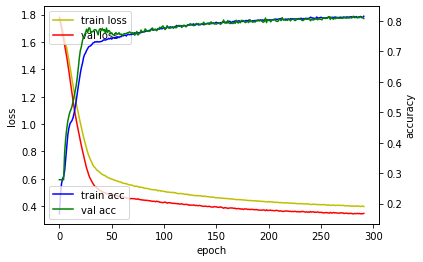

In [12]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()


In [13]:
# y_pred = model.predict(x_test)
y_pred = model.predict(test_x)
print(y_pred.shape)

y_pred_onehot = np.argmax(y_pred, axis=1)
print(y_pred[200] ,"===> onehot: ", y_pred_onehot[200])

y_test_argmax = np.argmax(test_y ,axis=1) 
y_pred_argmax = np.argmax(y_pred ,axis=1)
print(y_test_argmax.shape, y_pred_argmax.shape)

def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3, "walkback":4, "stand-sit": 5}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0, "walkback":0, "stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
            
        elif y_pred_argmax[i] == action_label["walkback"]:
            action_cnt["walkback"] +=1
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - walkback] ratio of walkback: ",  action_cnt["walkback"]/action_cnt["total_frames"])
        print("\t [ 5 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])
    return action_cnt
    
y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   

print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

(20369, 6)
[0.     0.     0.9707 0.0064 0.0229 0.    ] ===> onehot:  2
(20369,) (20369,)
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.13407629240512545
	 [ 1 - sit-stand] ratio of sit-stand:  0.048897834945259955
	 [ 2 - walk] ratio of walk:  0.21022141489518387
	 [ 3 - turn] ratio of turn:  0.17246796602680545
	 [ 4 - walkback] ratio of walkback:  0.17104423388482498
	 [ 5 - stand-sit] ratio of stand-sit:  0.26329225784280036
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.09313171977023908
	 [ 1 - sit-stand] ratio of sit-stand:  0.06146595316412195
	 [ 2 - walk] ratio of walk:  0.24119986253620698
	 [ 3 - turn] ratio of turn:  0.16333644263341351
	 [ 4 - walkback] ratio of walkback:  0.171731552849919
	 [ 5 - stand-sit] ratio of stand-sit:  0.26913446904609944
--->  # of Each Action Frames  
	 y_pred: {'total_frames': 20369, 'sit': 2731, 'sit-stand': 996, 'walk': 4282, 'turn': 3513, 'walkback': 3484, 'stand-sit': 5363}, 
	 y_test: {'total_frames': 20369, 'sit': 1897, 'sit-stand': 12

Cohens kappa: 0.776533
              precision    recall  f1-score   support

           0       0.47      0.68      0.56      1897
           1       0.84      0.67      0.74      1252
           2       0.98      0.85      0.91      4913
           3       0.92      0.97      0.95      3327
           4       0.92      0.91      0.92      3498
           5       0.74      0.72      0.73      5482

    accuracy                           0.82     20369
   macro avg       0.81      0.80      0.80     20369
weighted avg       0.84      0.82      0.83     20369


---> Confusion Matrix 
 [[1295   22    0    0    0  580]
 [ 125  834   28    0   10  255]
 [   0   30 4183  133  155  412]
 [   0    0   59 3235   33    0]
 [   0    0    3  145 3195  155]
 [1311  110    9    0   91 3961]]


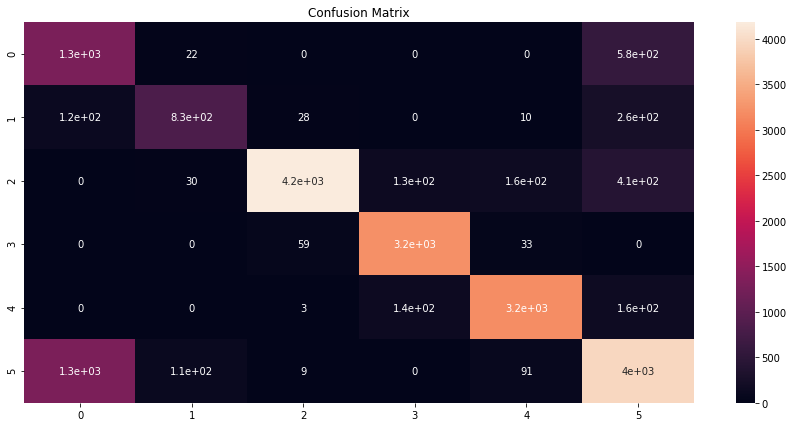

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
print('Cohens kappa: %f' % kappa)

print(classification_report(y_test_argmax, y_pred_argmax))

conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

plt.figure(figsize = (15,7) )
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.show()

#### PreProcessing for Saving LPF with oneHot encoded CSV (Fig)

In [ ]:
def preprocess_forSaving(actSplit=False, save = True):
    total_Trials = 0
    for dirpath, foldername, files in sorted(os.walk(datasetDir)):
        clear_output(wait=True)
        actPath = None
        pelvisPath= None
        actFrame = []
        if ".ipynb_checkpoints" in dirpath:
            continue
        else:
            for filename in sorted(files):
                if ".csv" in filename:
                    if "label_" in filename:
                        labelPath = dirpath
                        label_csv = os.path.join(labelPath,filename)
                        actFrame = get_actFrameNumber( label_csv)

                    if "skeleton_" in filename:          
                        pelvisPath = dirpath    
                        subname = dirpath.split("/")[-2] 
                        trial = dirpath.split("/")[-1] 
                        pelvis_csv = os.path.join(dirpath, filename)


                        frameNum, timstamp_ms, pelvis_x, pelvis_y, pelvis_z  = get_rawData(pelvis_csv)  # raw                 
                        pltSkeleton(timstamp_ms, pelvis_x, pelvis_y, pelvis_z, pelvisPath, subname +"_"+str(trial), actFrame, addFolder="raw", actSplit=actSplit, save=save) # ---> plot raw
                        normPelvis_x, normPelvis_y, normPelvis_z = get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max') # norm         
                        pltSkeleton(timstamp_ms, normPelvis_x, normPelvis_y, normPelvis_z, pelvisPath, subname +"_"+str(trial), actFrame, addFolder="norm", actSplit=actSplit, save=save) # ---> plot norm 
                        lpfPelvis_x, lpfPelvis_y, lpfPelvis_z = get_LPFData(normPelvis_x, normPelvis_y, normPelvis_z, cutoff_freq=0.5, order=1)  # lpf 
                        pltSkeleton(timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, pelvisPath, subname +"_"+str(trial), actFrame, addFolder= "lpf" + "_norm",actSplit=actSplit, save=save) # plot lpf   
                
                        total_Trials +=1   
                        if labelPath == pelvisPath:
                            print("\t ---->",pelvisPath, " \t act label ====> " +  str(actFrame) + "\n")         
                            oneHot_actionList = convert_act2oneHot(actFrame, frameNum)
                            
                            # --> raw skeleton data is used..
                            unLabel_rawData = np.array([timstamp_ms, pelvis_x, pelvis_y, pelvis_z]).T 
                            unLabel_lpfData = np.array([timstamp_ms, lpfPelvis_x, normPelvis_y, lpfPelvis_z]).T

                            raw_mergeData = np.zeros((len(unLabel_rawData), dataset_columns))
                            lpf_mergeData = np.zeros((len(unLabel_lpfData), dataset_columns))

                            raw_mergeData[:, :-(numActions)] = unLabel_rawData      # time , pelvis  넣음  (317,4) -- raw data  (time, x ,y, z)
                            raw_mergeData[:, -(numActions): ] = oneHot_actionList     #  (onehot encoded action = 6 )

                            lpf_mergeData[:, :-(numActions)] = unLabel_lpfData      # time , pelvis  넣음  (317,4) -- lpf applied
                            lpf_mergeData[:, -(numActions): ] = oneHot_actionList     # (335, 5) one hot encoding 수행한 actionsList          

                            # -- save data 
                            if save:  
                                if  os.path.isfile(pelvisPath + "/" + "raw_labeled_" +  subname +"_"+str(trial) + ".csv"):
                                    os.remove(pelvisPath + "/" + "raw_labeled_" +  subname +"_"+str(trial) + ".csv")
                                    os.remove(pelvisPath + "/" + "lpf_labeled_" +  subname +"_"+str(trial) + ".csv")
                                
                                np.savetxt(pelvisPath + "/" + "raw_labeled_" +  subname +"_"+str(trial) + ".csv", raw_mergeData, fmt='%s', delimiter=',')
                                np.savetxt(pelvisPath + "/" + "lpf_labeled_" +  subname +"_"+str(trial) + ".csv", lpf_mergeData, fmt='%s', delimiter=',')
                            
    return total_Trials
    
    
total_Trials = preprocess_forSaving(actSplit=True, save=True)
print("Total Trials: ", total_Trials)